<center><h1>Informarion Retrival Project</h1></center>
<center><h1>Build an Intelligent Information Retrival System</h1></center>

## Importation des librairies et du dataset

In [6]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from metric_tools import compute_metrics
import random
import re
import json
import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv("../csv_docs/dataset_dbscan.csv")
df.drop(columns = df.columns[0], axis = 1, inplace= True)
df

,18,told,biographi,briefli,describ,system,attempt,provid,decim,detail,...,anglo,supposit,morn,claus,inventor,sell,patente,monopoli,15%,9%
0,0.565909,0.64087,0.672031,0.410718,0.201332,0.145940,0.275780,0.209136,0.982483,0.29727,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.00000,0.000000,0.000000,0.000000,0.116752,0.000000,0.167309,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.000000,0.00000,0.000000,0.000000,0.000000,0.233504,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1456,0.000000,0.00000,0.000000,0.000000,0.000000,0.097293,0.183853,0.000000,0.000000,0.00000,...,0.527442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1457,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,1.054883,1.054883,1.054883,1.054883,1.054883,1.054883,1.054883,0.000000,0.000000
1458,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
fichier_inverse = pd.read_csv("../fichier_inverse.csv")
fichier_inverse = fichier_inverse.drop("Unnamed: 0", axis=1)
fichier_inverse

## Clusterisation des documents avec DBSCAN

In [3]:
# Retourner tous les points du dataset qui sont à une distance inférieure à eps de notre instance
def region_query(distances, i, eps):
    doc_indexes = np.where(distances[i] <= eps)[0] # On récupère les index des points qui sont à une distance inférieure à eps
    return [i for i in doc_indexes] # On retourne la liste des index des points

# Fonction qui permet de récursivement ajouter les points voisins à notre cluster
def expand_cluster(distances, document_cluster, clusters, C, neighbors, eps, min_pts):
    while len(neighbors)!=0: # Tant qu'il y a des voisins
        index_doc = neighbors.pop() # On récupère le premier voisin
        if index_doc == 1459: index_doc = 1458
        if document_cluster[index_doc] >=0 : continue # Si le point appartient déjà à un cluster et n'est pas du bruit, on passe au suivant
        document_cluster[index_doc] = C # On change la valeur -1 par le numéro du cluster pour indiquer que le point appartient à ce cluster
        clusters[C].append(index_doc) # On ajoute le point au cluster
        new_neighbors = region_query(distances,index_doc,eps) # On récupère les points voisins du point
        if len(new_neighbors)>= min_pts: neighbors.extend(new_neighbors) # Si le point a assez de voisins, on ajoute les voisins au cluster

# Fonction recréant l'algorithme DBSCAN
def dbscan(distances, eps, min_pts):
    # On itilisalise une liste a -1 pour chaque point du dataset (on ne connait pas encore son cluster)
    document_cluster = np.full(len(distances), (-1), dtype = np.int)
    clusters = [[]]
    noise = []
    C = 0
    for index_doc in range(len(distances)):
        if document_cluster[index_doc] != -1 : continue # Si le point appartient déjà à un cluster, on passe au suivant
        
        neighbors = region_query(distances,index_doc,eps) # On récupère les points voisins
        
        if len(neighbors) >= min_pts: # Si le point a assez de voisins, on crée un nouveau cluster
            document_cluster[index_doc] = C # On change la valeur -1 par le numéro du cluster pour indiquer que le point appartient à ce cluster
            clusters[C].append(index_doc) # On ajoute le point au cluster
            expand_cluster(distances, document_cluster, clusters, C, neighbors, eps, min_pts) # On ajoute les voisins du point au cluster
            C += 1 # On passe au cluster suivant
            clusters.append([])  # On initialise le nouveau cluster
        else : # Si le point n'a pas assez de voisins, on le considère comme du bruit
            document_cluster[index_doc] = -2 # On change la valeur -1 par -2 pour indiquer que le point est du bruit
            noise.append(index_doc) # On ajoute le point au bruit

            
    del clusters[C] # On supprime le dernier cluster qui est vide
    
    return clusters, noise

In [4]:
# Calculer la distance de manhattan entre tout les points du dataset
# Pour économiser du temps d'execution, on ne calcule que la matrice superieure de la matrice de distance
def manhattan_distance(df):
    distances = np.zeros((len(df), len(df)))
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            dist = np.sum(np.abs(df[i] - df[j]))
            
            distances[i][j] = dist
            distances[j][i] = dist

    return distances

# Fonction qui permet de calculer la distance de manhattan entre deux vecteurs en prenant en compte les valeurs communes
def manhattan_distance_with_coeff(df):
    distances = np.zeros((len(df), len(df))) # On initialise la matrice de distance
    for i in range(len(df)): # On parcourt tous les points du dataset
        for j in range(i+1, len(df)): # On parcourt tous les points du dataset
            
            index_a = np.where(df[i]>0)[0] # On récupère les index des valeurs non nulles du vecteur a
            index_b = np.where(df[j]>0)[0] # On récupère les index des valeurs non nulles du vecteur b
            common = np.intersect1d(index_a, index_b) # On récupère les index des valeurs communes
            
            # On multiplie par 5 le poid des valeurs non communes (Pour éloigner les documents avec beaucoup de valeurs non communes)
            new_a = df[i] * 5 
            new_b = df[j] * 5
            
            # On divise par 100 le poid des valeurs communes (Pour rapprocher les documents avec beaucoup de valeurs communes)
            new_a[common] = df[i][common] * 0.01
            new_b[common] = df[j][common] * 0.01
            
            dist = np.sum(np.abs(new_a - new_b)) # On calcule la distance de manhattan
            
            # On divise par le nombre de valeurs communes si il y en a plus que de valeurs non communes (Toujours pour rapprocher les documents avec beaucoup de valeurs communes)
            if len(common) > len(df[i]) - len(common): dist = dist / len(common) 
            else: dist = dist * (len(df[i]) - len(common)) # On multiplie par le nombre de valeurs non communes si il y en a plus que de valeurs communes (Toujours pour éloigner les documents avec beaucoup de valeurs non communes)
            
            # On met la distance entre le document i et le document j et la distance entre le document j et le document i à la même valeur
            distances[i][j] = dist 
            distances[j][i] = dist 

# Fonction qui permet de calculer la distance de Dice entre deux documents
def dice_distance(fichier_inverse):
    distances = None
    for d in sorted(fichier_inverse["Document"].unique()):
        words = list(fichier_inverse.loc[fichier_inverse["Document"] == d, "Word"].unique()) # Liste des mots du document d
        df = fichier_inverse.loc[fichier_inverse["Word"].isin(words),["Document","Word","Poid"]] # On récupère les documents qui ont au moins un mot en commun avec le document d
        df = df.loc[df["Document"] != d, :] # On supprime le document d
        n = df.groupby('Document')['Word'].count().to_frame() # on compte le nombre de mots par document
        df = df.groupby('Document')['Poid'].sum().to_frame() # on somme les poids des mots de la requête
        df.reset_index(inplace=True) # on remet les documents en colonne
        df.rename(columns = {'Poid':'Scalar weight'}, inplace = True)  # on renomme la colonne


        weights_doc = fichier_inverse.copy() # on copie le fichier inverse

        weights_doc["Poid"] = np.power(weights_doc["Poid"], 2) # on calcule le carré des poids

        weights_doc = weights_doc.groupby('Document')['Poid'].sum().to_frame() # on somme les carrés des poids

        weights_doc.rename(columns = {'Poid':'weight docs'}, inplace = True) # on renomme la colonne
        
        df = df.merge(weights_doc, on="Document") # on fusionne les deux dataframes

        df["weight doc"] = n.to_numpy() # on ajoute la colonne du nombre de mots du document d
        
        df["RSV"] = np.divide( # on divise le poids de la requête par le produit des racines carrées des poids de la requête et du document
                            np.multiply(df["Scalar weight"], 2),
                            np.add(df["weight doc"], df["weight docs"]))

        df = df[["Document", "RSV"]]
        df["Document"] = df["Document"].apply(lambda x: x.split("D")[1]) # on supprime l'extension du nom du document
        df["Document"] = df["Document"].astype(int) # on convertit le nom du document en entier
        for i in range(1, 1460):
            if i not in df["Document"].unique():
                df = df.append({"Document": i, "RSV": 0}, ignore_index=True)
        df["RSV"] = 1 - df["RSV"] # on inverse les valeurs
        df.rename(columns = {'RSV': d}, inplace = True) # on renomme la colonne
        df = df.sort_values(by=["Document"]) # on trie les documents par poids
        
        # on fusionne les dataframes
        if distances is None: 
            distances = df
        else: 
            distances = distances.merge(df, on="Document")
    
    return distances

In [ ]:
distances.drop("Document", axis=1, inplace=True)
distances.to_csv("../distances.csv", index=False)

In [5]:
distances = pd.read_csv("../distances.csv").to_numpy()
distances

array([[1.        , 0.94211934, 0.79439579, ..., 0.85990716, 0.95986786,
        0.93106985],
       [1.        , 0.73805684, 0.81522626, ..., 0.79508038, 0.79508038,
        0.95218339],
       [0.9248936 , 0.91205711, 0.72949473, ..., 1.        , 0.84442234,
        0.87858377],
       ...,
       [0.75408656, 0.76757146, 0.71112712, ..., 0.823416  , 0.75504815,
        0.91217535],
       [1.        , 0.92878937, 0.87523715, ..., 0.98427099, 0.94055683,
        1.        ],
       [1.        , 0.88525502, 0.9049204 , ..., 1.        , 1.        ,
        0.9542612 ]])

In [5]:
def calcule_distances(df, methode):
    if methode == "manhattan": return manhattan_distance(df)
    elif methode == "manhattan_with_coeff": return manhattan_distance_with_coeff(df)
    elif methode == "dice": return dice_distance(df)

In [ ]:
distances = calcule_distances(df.to_numpy(), methode = "manhattan")

In [10]:
clusters = dbscan(distances, 50, 3)
len(clusters), len(clusters[0]), len(clusters[1])

(2, 1, 38)

Résultat insufisant essayons une autre méthode

## DBSCAN après nettoyage et réduction des dimmensions

In [9]:
number_cols = [x for x in df.columns if re.search(r'\d', x)] # On récupère les colonnes contenant des chiffres
percent_num = 100 * len(number_cols) / len(df.columns) # On calcule le pourcentage de colonnes contenant des chiffres

print(f"{percent_num:.2f}% of the columns are numbers") # On affiche le pourcentage de colonnes contenant des chiffres

7.07% of the columns are numbers


Les valeurs numérique représentant souvent un problème lors du clustering en text mining nous allons les supprimer

In [10]:
df_clean = df.copy() # On copie le dataset
for c in number_cols:
    df_clean.drop(c, axis=1, inplace=True)
df.shape, df_clean.shape

((1460, 6929), (1460, 6439))

In [11]:
# On applique PCA pour la réduction de dimension
def pca_decomp(df, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(df)
    df_pca = pca.transform(df)
    df_pca = pd.DataFrame(df_pca)
    return pca, df_pca

In [12]:
pca, df_pca = pca_decomp(df_clean, 18)
df_pca 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.162223,-0.033614,-0.053589,0.019592,-0.114503,0.329911,-0.199963,-0.123973,0.063422,-0.226674,0.003254,-0.385038,-0.452281,0.226566,-0.004534,-0.245701,-0.019607,-0.145216
1,-0.179292,-0.030928,0.117684,-0.068651,-0.049815,-0.123002,-0.085362,0.110274,-0.144923,0.073120,0.023499,-0.067145,0.019826,0.204324,0.045420,-0.019613,-0.008030,0.075375
2,-0.097130,0.028816,-0.096119,0.073564,-0.107068,-0.039025,-0.087303,-0.093104,0.174473,-0.152964,-0.169245,0.184608,0.233656,0.326478,-0.023966,0.099233,0.053200,0.234494
3,-0.334562,-0.073451,0.338164,0.014805,-0.087599,-0.063102,-0.097407,0.123036,-0.150240,0.135655,0.216837,-0.059363,-0.075760,-0.062396,-0.020201,-0.137768,-0.005336,0.127807
4,-0.181677,-0.001064,0.004972,0.157628,0.016384,-0.068232,-0.043263,-0.055391,-0.056023,0.029057,0.172292,-0.207354,0.077441,-0.185084,0.108879,-0.135967,0.377507,0.122138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.251296,-0.021151,-0.183376,0.063802,-0.082389,-0.064080,-0.017167,-0.107319,-0.003510,-0.002508,-0.011048,0.044558,0.239036,0.114347,-0.068869,-0.140871,0.123538,-0.164210
1456,-0.468562,-0.018169,0.207268,0.043093,0.046632,0.001016,-0.163787,-0.020365,-0.099589,0.098363,0.217157,-0.015091,-0.019506,0.105928,-0.092057,-0.072380,-0.027214,0.015909
1457,-0.312476,0.017380,-0.332695,0.066071,-0.074216,-0.065505,-0.112986,-0.053991,0.157507,-0.073056,0.009885,0.247348,-0.320581,-0.203360,0.209855,-0.344610,-0.008101,0.416613
1458,0.075219,0.011570,-0.175098,0.087011,-0.240106,0.143484,-0.180987,0.242727,0.141662,0.105313,0.056728,0.025552,0.068940,0.085618,-0.099034,0.270660,-0.092483,0.053720


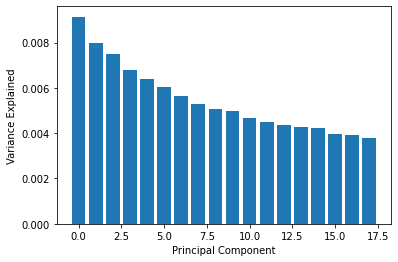

In [10]:
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [22]:
distances = calcule_distances(df_pca.to_numpy(), methode = "manhattan")

In [25]:
clusters = dbscan(distances, 4, 3)
len(clusters), len(clusters[0]), len(clusters[1])

(2, 1, 40)

Résultats toujours non satisfaisant

## DBSCAN après feature selection

### Feature selection en utilisant les poids

In [5]:
new_df = df.sum(axis=0).sort_values(ascending=False).to_frame()
new_df.reset_index(inplace=True)
new_df.rename(columns = {'index':'word'}, inplace = True)
new_df.rename(columns = {0:'Poid'}, inplace = True)
new_df

,word,Poid
0,librari,198.338388
1,inform,169.964706
2,system,147.625983
3,use,115.767955
4,index,105.729013
...,...,...
6924,nonrandomli,0.210977
6925,levi,0.117209
6926,newberri,0.117209
6927,linda,0.117209


In [6]:
selected_word = new_df.loc[new_df["Poid"] > 70]["word"].to_numpy()
len(selected_word)

20

In [9]:
distances = calcule_distances(df[selected_word].to_numpy(), methode = "manhattan")
distances

array([[0.        , 2.01752234, 0.53898566, ..., 0.92175936, 0.83257521,
        2.63370226],
       [2.01752234, 0.        , 1.47853668, ..., 1.4231289 , 2.20729771,
        3.20209213],
       [0.53898566, 1.47853668, 0.        , ..., 0.81794518, 0.72876103,
        2.38659653],
       ...,
       [0.92175936, 1.4231289 , 0.81794518, ..., 0.        , 1.11153473,
        3.20454172],
       [0.83257521, 2.20729771, 0.72876103, ..., 1.11153473, 0.        ,
        3.11535756],
       [2.63370226, 3.20209213, 2.38659653, ..., 3.20454172, 3.11535756,
        0.        ]])

In [15]:
dist = distances.copy()
dist[dist == 0] = 1000
dist.min(), distances.max()

(0.01171615528055795, 7.728244098387436)

In [52]:
clusters, noise = dbscan(distances, 0.4, 5)
print(len(clusters), len(noise))
for c in clusters:
    print(len(c))

5 1002
417
16
12
11
6


Amélioratuon mais toujours des résultats non satisfaisant

### Feature selection en utilisant les fréquences et K means

In [80]:
df_freq = fichier_inverse.groupby("Word")["Frequence"].sum().to_frame()
df_freq.reset_index(inplace=True)
df_freq = df_freq.sort_values(by=["Frequence"]) 
df_freq = df_freq.reindex(index=df_freq.index[::-1])
df_freq = df_freq.loc[df_freq["Frequence"] < 100]
df_freq

,Word,Frequence
692,analyz,99
6633,util,98
3784,machin,98
1271,catalogu,98
1878,decis,97
...,...,...
2584,file-manag,1
5186,realkatalog,1
2580,fig,1
2579,fifty-thre,1


In [107]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=20).fit(new_df["Poid"].to_numpy().reshape(-1, 1))

In [108]:
for i in range(20):
    print(len(np.where(clusters.labels_ == i)[0]))

1732
63
2
148
72
20
2
422
5
27
125
2822
291
842
8
21
91
193
1
42


In [120]:
df_clusters = pd.DataFrame()
for i in range(20):
    words = new_df.iloc[np.where(clusters.labels_ == i)[0]]["word"].to_numpy()
    df_clusters["Cluster "+str(i+1)] = df[words].sum(axis=1)
df_clusters

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12,Cluster 13,Cluster 14,Cluster 15,Cluster 16,Cluster 17,Cluster 18,Cluster 19,Cluster 20
0,0.000000,1.215993,0.000000,0.000000,1.395684,1.191914,0.145940,1.874304,0.000000,0.209136,0.413886,1.582325,2.503981,4.388761,0.175460,0.201332,2.575038,2.248579,0.00000,0.769305
1,0.320435,0.416998,0.380775,1.438930,0.970487,0.510115,0.444238,1.328241,0.308849,0.909419,0.700764,0.791163,0.746580,0.862228,0.000000,0.000000,0.689825,1.539101,0.56226,0.643950
2,0.000000,1.570065,0.000000,2.844258,0.537412,0.000000,0.217586,0.877327,0.000000,0.406869,0.224862,0.861224,1.639981,1.414704,0.000000,0.708833,1.151465,0.264048,0.00000,1.448014
3,4.451863,1.599306,0.000000,0.966901,0.471665,0.652862,0.218292,0.452727,0.281121,0.784758,0.564307,0.000000,1.508874,0.000000,0.162709,0.750317,0.000000,1.329562,0.56226,1.286366
4,0.000000,0.615811,0.423083,0.521894,1.946135,0.559184,0.000000,4.985242,0.117134,1.349846,2.942192,0.477320,2.574625,1.602553,0.114628,0.307144,1.142059,1.393443,0.09371,1.585796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.603782,1.250918,0.000000,2.832183,4.362132,0.296780,0.233504,1.749770,0.155383,0.196348,2.086228,0.632930,1.154117,0.477597,0.277922,0.155879,0.806548,3.074385,0.00000,1.426726
1456,0.427247,1.986533,0.000000,1.673228,2.578115,0.388230,0.097293,2.493519,0.000000,0.469978,1.023831,1.004761,1.259908,0.386889,0.114628,0.284454,1.148750,0.613108,0.56226,0.851734
1457,10.130905,1.169119,0.338467,5.481784,0.849697,0.291472,0.000000,7.219168,0.261893,0.000000,4.419047,0.000000,7.247254,3.420452,0.000000,0.000000,0.591262,6.797794,0.00000,2.395756
1458,0.000000,1.068804,0.000000,1.140331,0.861605,0.992151,0.000000,0.000000,0.258971,0.661154,1.062893,0.000000,1.358876,2.504982,0.252204,0.676113,0.885312,2.273069,0.00000,0.000000


In [121]:
cluster_distances = manhattan_distance(df_clusters.to_numpy())
cluster_distances

array([[ 0.        , 15.92069722, 16.03282973, ..., 43.24159156,
        13.04785871, 27.23675978],
       [15.92069722,  0.        , 11.49545345, ..., 43.51838981,
        10.78547857, 18.43707675],
       [16.03282973, 11.49545345,  0.        , ..., 42.7587429 ,
        12.2084499 , 18.23504029],
       ...,
       [43.24159156, 43.51838981, 42.7587429 , ...,  0.        ,
        41.80981724, 40.82209541],
       [13.04785871, 10.78547857, 12.2084499 , ..., 41.80981724,
         0.        , 18.93179098],
       [27.23675978, 18.43707675, 18.23504029, ..., 40.82209541,
        18.93179098,  0.        ]])

In [128]:
clusters, noise = dbscan(cluster_distances, 15, 3)
len(clusters), len(noise)

(1, 62)

Résultats non satisfaisants

### Feature selection en utilisant les transformers

In [7]:
documents = open("../cisi/CISI.ALL").read()
def split_extraction(documents):
    content = documents.split(".I ") # Split sur le numéro de document
    del content[0] # Suppression du premier élément qui est vide

    parts = content 
    data = [] # Liste qui contiendra les données
    for part in parts: # Pour chaque document
        
        temp = part.split(".T\n") # Split sur le titre
        if len(temp) == 1 : temp = part.split(".T \n") # Si le titre prend un espace avant de retourner à la ligne
        if len(temp) == 1 : temp = part.split(".T  \n") # Si le titre prend deux espaces avant de retourner à la ligne
        
        del temp[0] # Suppression du premier élément qui est vide
        aut_temp = temp[0].split(".A\n") if len(temp[0].split(".A\n")) >= 2 else temp[0].split(".A \n") # Split sur l'auteur (si l'auteur prend un espace avant de retourner à la ligne)
        if len(aut_temp) > 2 : # Si le document a plus d'un auteur
            while len(aut_temp) != 2: # On supprime l'intégralité des auteurs 
                del aut_temp[1]
        title, temp2 = aut_temp # On récupère le titre et le reste du document
        
        summary = temp2.split(".W\n")[-1].split(".X")[0] # On récupère le résumé et on supprime les références
        summary = summary.split(".W")[-1] # On re applique un split afin de gérer un cas particulier
        data.append([' '.join(title.split()).lower(),' '.join(summary.split()).lower()]) # On ajoute le titre et le résumé dans la liste
    return data
data = split_extraction(documents)
text = ""
for d in data:
    text += ' '.join(d) + " " 
full_text = ''.join(text) + " " 

In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
word_clusters = model.encode(full_text)
word_clusters

array([array(['period', 'morn', 'night', 'forenoon', 'fortnight', 'phase',
       'month', 'week', 'stage', 'era', 'year'], dtype='<U9'),
       array(['book', 'workbook', 'encyclopedia', 'reprint', 'pamphlet',
       'textbook', 'catalog', 'read', 'handbook'], dtype='<U12'),
       array(['scholar', 'plato', 'popper', 'generalist', 'steiner', 'pundit',
       'humanist', 'berkeley', 'hartley', 'realist', 'trevelyan',
       'historian'], dtype='<U10'),
       array(['de', 'il', 'connecticut', 'vermont', 'maryland', 'hawaii',
       'georgia', 'sd', 'ia', 'pennsylvania', 'florida', 'indiana',
       'colorado', 'minnesota', 'missouri', 'california', 'virginia',
       'michigan', 'ct', 'oh', 'ohio'], dtype='<U12'),
       array(['luxembourg', 'colombo', 'lusaka', 'kiev', 'moscow', 'vienna',
       'rome', 'copenhagen', 'washington', 'london'], dtype='<U10'),
       array(['author', 'asimov', 'anderson', 'stephen', 'poe', 'hesiod',
       'pushkin', 'fletcher', 'johnson', 'vega', 'coaut

In [10]:
save_state = dict()
i = 1
for wc in word_clusters:
    save_state["Group"+str(i)] = wc.tolist()
    i+=1

with open("../groups.json", "w") as write_file:
    json.dump(save_state, write_file, indent=4)

In [11]:
word_clusters = list(json.load(open("../groups.json")).values())
word_clusters = np.array([np.array(c) for c in word_clusters])
word_clusters

array([array(['period', 'morn', 'night', 'forenoon', 'fortnight', 'phase',
       'month', 'week', 'stage', 'era', 'year'], dtype='<U9'),
       array(['book', 'workbook', 'encyclopedia', 'reprint', 'pamphlet',
       'textbook', 'catalog', 'read', 'handbook'], dtype='<U12'),
       array(['scholar', 'plato', 'popper', 'generalist', 'steiner', 'pundit',
       'humanist', 'berkeley', 'hartley', 'realist', 'trevelyan',
       'historian'], dtype='<U10'),
       array(['de', 'il', 'connecticut', 'vermont', 'maryland', 'hawaii',
       'georgia', 'sd', 'ia', 'pennsylvania', 'florida', 'indiana',
       'colorado', 'minnesota', 'missouri', 'california', 'virginia',
       'michigan', 'ct', 'oh', 'ohio'], dtype='<U12'),
       array(['luxembourg', 'colombo', 'lusaka', 'kiev', 'moscow', 'vienna',
       'rome', 'copenhagen', 'washington', 'london'], dtype='<U10'),
       array(['author', 'asimov', 'anderson', 'stephen', 'poe', 'hesiod',
       'pushkin', 'fletcher', 'johnson', 'vega', 'coaut

In [12]:
df_clusters = pd.DataFrame()
i = 1
for c in word_clusters:
    df_clusters["Cluster "+str(i)] = df[c].sum(axis=1)
    i += 1
df_clusters

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10
0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.143404,0.270915,0.0,0.0,0.0,0.000000,0.0,0.185487,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.126372,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.354757,0.0,0.0
4,0.150689,0.000000,0.0,0.0,0.0,0.000000,0.0,0.123658,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1455,0.000000,0.155383,0.0,0.0,0.0,0.000000,0.0,0.296780,0.0,0.0
1456,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.123658,0.0,0.0
1457,1.850878,0.000000,0.0,0.0,0.0,0.340128,0.0,0.000000,0.0,0.0
1458,0.000000,0.258971,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [83]:
cluster_distances = df
cluster_distances

array([[1.        , 0.94211934, 0.79439579, ..., 0.85990716, 0.95986786,
        0.93106985],
       [1.        , 0.73805684, 0.81522626, ..., 0.79508038, 0.79508038,
        0.95218339],
       [0.9248936 , 0.91205711, 0.72949473, ..., 1.        , 0.84442234,
        0.87858377],
       ...,
       [0.75408656, 0.76757146, 0.71112712, ..., 0.823416  , 0.75504815,
        0.91217535],
       [1.        , 0.92878937, 0.87523715, ..., 0.98427099, 0.94055683,
        1.        ],
       [1.        , 0.88525502, 0.9049204 , ..., 1.        , 1.        ,
        0.9542612 ]])

In [1]:
clusters, noise = dbscan(cluster_distances, 0.6, 200)
print(len(clusters), len(noise))
for c in clusters:
    print(len(c))

6 521
231
189
102
137
142
138


## Classification des documents avec Naïve Bayes

In [2]:
fichier_inverse_nb = fichier_inverse.copy()
fichier_inverse_nb["Cluster"] = -1
for c in clusters:
    cc = np.array(c, dtype=str)
    cc= ["D" + item for item in cc]
    fichier_inverse_nb["Cluster"].loc[fichier_inverse_nb["Document"].isin(cc)] = clusters.index(c)

In [102]:
docs_nb = 0

for c in clusters:
    docs_nb = docs_nb + len(c)
unique_terms =sorted(list(df.columns))[1:] # On récupère les termes uniques
df_nb = pd.DataFrame(columns = unique_terms)
freq_cluster_word = fichier_inverse_nb.groupby(["Cluster", "Word"])["Frequence"].sum().to_frame()
freq_cluster_word.reset_index(inplace=True)

for i in range(len(clusters)):
    df_nb.loc[i] = np.zeros(len(unique_terms))
    freq_word = freq_cluster_word.loc[freq_cluster_word['Cluster'] == i]
    freq_word = freq_word.loc[freq_word["Word"].isin(list(df_clean.columns))] # On supprime les colonnes contenant des chiffres
    df_nb.loc[i][freq_word["Word"]] = freq_word["Frequence"].to_numpy()
    df_nb.loc[i] += 1 
    df_nb.loc[i] /= freq_word["Frequence"].sum()
proba = []
for i in range(len(clusters)):
    proba.append(len(clusters[i]) / docs_nb)
df_nb["Prob(Cluster)"] = proba
df_nb

,0.18,0.5,0.7%,000,029,044,054,071,071182,073,...,zero,zero-on,zhurnal,ziman,zipf,zipfian,zone,zoolog,zuckerman,Prob(Cluster)
0,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,...,0.000058,0.000058,0.000058,0.000173,0.000058,0.000058,0.000173,0.000058,0.000058,0.248248
1,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,...,0.000142,0.000085,0.000028,0.000028,0.000227,0.000057,0.000028,0.000028,0.000028,0.520521
2,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,...,0.000130,0.000130,0.000130,0.000130,0.000261,0.000130,0.000130,0.000130,0.000130,0.104104
3,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,0.000265,...,0.000265,0.000265,0.000531,0.000265,0.000265,0.000265,0.000265,0.000265,0.000531,0.050050
4,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,...,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.000298,0.044044
5,0.000460,0.000460,0.000460,0.000460,0.000460,0.000460,0.000460,0.000460,0.000460,0.000460,...,0.000460,0.000460,0.000460,0.000460,0.000460,0.000460,0.000460,0.000460,0.000460,0.033033


In [11]:
info_queries = pd.read_csv("../info_queries.csv")
info_queries.drop(columns = info_queries.columns[0], axis = 1, inplace= True)
info_queries

,Query,Word
0,Q1,problem
1,Q1,concern
2,Q1,make
3,Q1,descript
4,Q1,titl
...,...,...
5188,Q112,algorithm
5189,Q112,compar
5190,Q112,previous
5191,Q112,describ


In [4]:
eval_df = pd.read_csv("../csv_docs/evaluation.csv")
eval_df = eval_df.drop("Unnamed: 0", axis=1)
eval_df

,Query,Document
0,Q1,D28
1,Q1,D35
2,Q1,D38
3,Q1,D42
4,Q1,D43
...,...,...
3109,Q111,D422
3110,Q111,D448
3111,Q111,D485
3112,Q111,D503


In [13]:
# Fonction recréant l'algorithme Naive Bayes
def naive_bayes(info_queries, df):
    number_cols = [x for x in df.columns if re.search(r'\d', x)] # On récupère les colonnes contenant des nombres
    df_clean = df.copy()  # On crée une copie du dataframe
    for c in number_cols: 
        df_clean.drop(c, axis=1, inplace=True) # On supprime les colonnes contenant des nombres
    queries = info_queries["Query"].unique() # On récupère les requêtes
    y_pred = [] # On initialise la liste des prédictions
    for q in queries: # Pour chaque requête
        probas = [] # On initialise la liste des probabilités
        for i in range(len(df)): # Pour chaque document
            iq = info_queries.loc[info_queries["Query"] == q] # On récupère les informations de la requête
            probas.append(df.loc[i][iq.loc[iq["Word"].isin(list(df_clean.columns))]["Word"].to_numpy()].prod() * df.loc[i]["Prob(Cluster)"]) # On calcule la probabilité du document pour la requête
        y_pred.append([q, np.argmax(probas)]) # On ajoute la prédiction pour la requête
    return y_pred # On retourne la liste des prédictions

## Application de notre SRI et évaluation

In [15]:
# Fonction représentant le fonctionnement de notre SRI basé text mining
def text_mining_sri(query, info_queries, df, fichier_inverse, radius, min_pts):
    cluster_distances = pd.read_csv("../csv_docs/distances.csv").to_numpy() # On récupère les distances entre les documents
    clusters, noise = dbscan(cluster_distances, radius, min_pts) # On récupère les clusters et le bruit
    fichier_inverse_nb = fichier_inverse.copy() # On crée une copie du fichier inverse
    fichier_inverse_nb["Cluster"] = -1 # On initialise la colonne Cluster à -1
    for c in clusters: # Pour chaque cluster
        cc = np.array(c, dtype=str) # On convertit les numéros de documents en chaînes de caractères
        cc= ["D" + item for item in cc] # On ajoute un D devant chaque numéro de document
        fichier_inverse_nb["Cluster"].loc[fichier_inverse_nb["Document"].isin(cc)] = clusters.index(c) # On change la valeur -1 par le numéro du cluster pour indiquer que le document appartient à ce cluster
    docs_nb = 0 # On initialise le nombre de documents
    for c in clusters: # Pour chaque cluster
        docs_nb = docs_nb + len(c) # On ajoute le nombre de documents du cluster au nombre total de documents
    unique_terms =sorted(list(df.columns))[1:] # On récupère les termes uniques
    df_nb = pd.DataFrame(columns = unique_terms) # On crée un dataframe contenant les termes uniques
    freq_cluster_word = fichier_inverse_nb.groupby(["Cluster", "Word"])["Frequence"].sum().to_frame() # On récupère la fréquence des termes par cluster
    freq_cluster_word.reset_index(inplace=True) # On réinitialise l'index
    number_cols = [x for x in df.columns if re.search(r'\d', x)] # On récupère les colonnes contenant des nombres
    df_clean = df.copy()  # On crée une copie du dataframe
    for c in number_cols:  
        df_clean.drop(c, axis=1, inplace=True) # On supprime les colonnes contenant des nombres
    for i in range(len(clusters)): # Pour chaque cluster
        df_nb.loc[i] = np.zeros(len(unique_terms)) # On initialise la ligne du cluster à 0
        freq_word = freq_cluster_word.loc[freq_cluster_word['Cluster'] == i] # On récupère les termes du cluster
        freq_word = freq_word.loc[freq_word["Word"].isin(list(df_clean.columns))] # On supprime les colonnes contenant des chiffres
        df_nb.loc[i][freq_word["Word"]] = freq_word["Frequence"].to_numpy() # On ajoute la fréquence des termes du cluster
        df_nb.loc[i] += 1  # On ajoute 1 à chaque terme du cluster
        df_nb.loc[i] /= freq_word["Frequence"].sum() # On divise chaque terme du cluster par la somme des fréquences du cluster
    proba = [] # On initialise la liste des probabilités
    for i in range(len(clusters)): # Pour chaque cluster
        proba.append(len(clusters[i]) / docs_nb) # On calcule la probabilité du cluster
    df_nb["Prob(Cluster)"] = proba # On ajoute la probabilité du cluster au dataframe
    y_pred = naive_bayes(info_queries.loc[info_queries["Query"] == query], df_nb)[0][1] # On récupère le cluster prédit par Naive Bayes

    y_pred = sorted(y_pred) # On trie la liste des prédictions
    y_pred = ["D"+str(x) for x in y_pred] # On ajoute un D devant chaque numéro de document
    if y_pred[0] == "D0": y_pred = y_pred[1:] # On supprime le document D0 s'il est présent

    return pd.DataFrame(y_pred, columns = ["Document"]) # On retourne la liste des prédictions

text_mining_sri("Q1", info_queries, df, fichier_inverse, 0.6, 200)

,Document
0,D10
1,D28
2,D35
3,D38
4,D42
5,D43
6,D49
7,D52
8,D65
9,D71


In [5]:
metrics = []
for query in info_queries["Query"].unique():
    tm_result = text_mining_sri(query, info_queries, df, fichier_inverse, 0.6, 200)
    p, p5, p10, r, f = compute_metrics(query, eval_df, tm_result)
    metrics.append([query, p, r, f])
metrics = pd.DataFrame(metrics, columns=["Query", "Precision", "Rappel", "F-Mesure"])
metrics

,Query,Precision,Rappel,F-Mesure
0,Q1,0.034860,1.0,0.067371
1,Q2,0.018506,1.0,0.036339
2,Q3,0.030178,1.0,0.058589
3,Q4,0.005487,1.0,0.010914
4,Q5,0.016461,1.0,0.032389
...,...,...,...,...
107,Q108,0.000000,0.0,0.000000
108,Q109,0.048697,1.0,0.092871
109,Q110,0.000000,0.0,0.000000
110,Q111,0.004115,1.0,0.008197


In [21]:
metrics.to_csv("../csv_docs/tm_metrics.csv", index=False)